In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
import numpy as np
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

# Build Model

In [ ]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding = (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)  

In [ ]:
from collections import OrderedDict

class ResNetGate(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.blocks = nn.Sequential(OrderedDict({
            'conv': Conv2dAuto(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, bias=False)
            ,'bn': nn.BatchNorm2d(out_channels)
            ,'activation': nn.ReLU()
            ,'mp': nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            }))
    
    def forward(self, x):
        return self.blocks(x)

In [ ]:
from collections import OrderedDict

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

In [ ]:
class ResNetBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv=conv3x3, activation=nn.ReLU):
        super().__init__()
        self.in_channels, self.out_channels, self.conv = in_channels, out_channels, conv

        stride = 2 if in_channels != out_channels else 1

        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1,
                      stride=2, bias=False),
            nn.BatchNorm2d(self.out_channels)
        ) if self.apply_shortcut else None

        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, self.conv, stride=stride)
            ,activation()
            ,conv_bn(self.out_channels, self.out_channels, self.conv)
        )

    @property
    def apply_shortcut(self):
        return self.in_channels != self.out_channels
    
    def forward(self, x):
        residual = x
        if self.apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x

In [ ]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, activation=nn.ReLU, *args, **kwargs):
        super().__init__()

        self.blocks = nn.Sequential(
            block(in_channels, out_channels, activation=activation, *args, **kwargs),
            *[block(out_channels, out_channels, activation=activation, *args, **kwargs) for n in range(n-1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [ ]:
class ResNetEncoder(nn.Module):
    def __init__(self, in_channels=3, layer_sizes=[2,2,2,2], block_sizes=[64, 128, 256, 512]
                ,activation=nn.ReLU, block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()

        self.gate = ResNetGate(in_channels, block_sizes[0], kernel_size=7, stride=2)

        self.in_out_block_sizes = list(zip(block_sizes, block_sizes[1:]))

        self.encoder = nn.ModuleList([
            ResNetLayer(block_sizes[0], block_sizes[0], block=block, n=layer_sizes[0], activation=activation)
            ,*[ResNetLayer(in_channels, out_channels, block=block, n=depth, activation=activation) 
                for (in_channels, out_channels), depth in zip(self.in_out_block_sizes, layer_sizes[1:])]]
        )

    def forward(self, x):
        x = self.gate(x)
        for layer in self.encoder:
            x = layer(x)
        return x

In [ ]:
class ResNetDecoder(nn.Module):
    def __init__(self, in_features, n_classes, *args, **kwargs):
        super().__init__()

        self.avgPool = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avgPool(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()

        self.encoder = ResNetEncoder(in_channels=in_channels, *args, **kwargs)
        self.decoder = ResNetDecoder(self.encoder.encoder[-1].blocks[-1].out_channels, n_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, layer_sizes=[3, 4, 6, 3])

In [ ]:
test_image = torch.Tensor(np.ones((1,3,224,224)))

resnet34_test = resnet34(3, 10)
resnet34_test(test_image).shape

torch.Size([1, 10])

# Compare Models

In [ ]:
from torchsummary import summary

summary(resnet34_test.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dAuto-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
        ResNetGate-5           [-1, 64, 56, 56]               0
        Conv2dAuto-6           [-1, 64, 56, 56]          36,864
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
        Conv2dAuto-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
 ResNetBasicBlock-11           [-1, 64, 56, 56]               0
       Conv2dAuto-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
import torchvision.models as models

summary(models.resnet34(False).cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Image Augmentation

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

Files already downloaded and verified


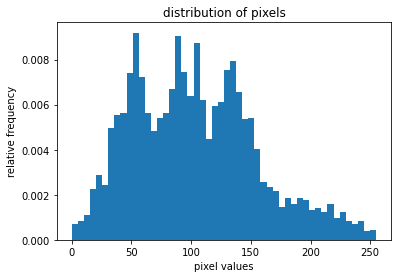

In [ ]:
img_pil = trainset[0][0]

plt.hist(np.array(img_pil).ravel(), bins=50, density=True);
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testset, valset = random_split(testset,[8000,2000])

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Files already downloaded and verified


In [ ]:
len(trainset)

50000

In [ ]:
testset, new_trainset = random_split(trainset,[46000,4000])

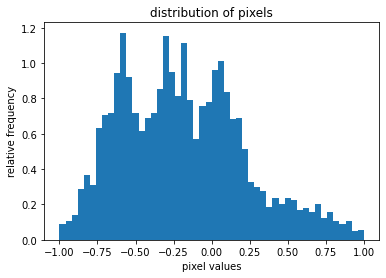

In [ ]:
img_pil2 = trainset[0][0]

plt.hist(np.array(img_pil2).ravel(), bins=50, density=True);
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

# Train Model

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet34_test.parameters(), lr=0.001, momentum=0.9)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
resnet34_test.to(device)

ResNet(
  (encoder): ResNetEncoder(
    (gate): ResNetGate(
      (blocks): Sequential(
        (conv): Conv2dAuto(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
        (mp): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
    )
    (encoder): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): B

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet34_test(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.614


[1,  4000] loss: 2.055


[1,  6000] loss: 1.907


[1,  8000] loss: 1.827


[1, 10000] loss: 1.780


[1, 12000] loss: 1.744


Finished Training


In [ ]:
epochs = []
train_losses = []
val_losses = []

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    train_loss = 0
    for i, data in enumerate(trainloader, 0):
        epoch_loss = 0
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet34_test(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss += running_loss / 2000
            running_loss = 0.0

    val_loss = 0
    for i, data in enumerate(valloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = resnet34_test(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss

    epochs.append(epoch+1)
    train_losses.append(train_loss)
    val_losses.append(val_loss / len(valset))


print('Finished Training')


# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         running_loss =+ loss.item() * images.size(0)

#     loss_values.append(running_loss / len(train_dataset))

# plt.plot(loss_values)

KeyboardInterrupt: 

### Save Model

In [ ]:
PATH = './cifar_resnet.pth'
torch.save(resnet34_test.state_dict(), PATH)

In [ ]:
!ls cifar_resnet.pth

# Visualize Training Loss

In [ ]:
loss_val = []

for tensor in val_losses:
    loss_val.append(tensor.detach().cpu())

In [ ]:
loss_val

[]

In [ ]:
# loss_train = np.array(train_losses)
# loss_val = np.array(torch.Tensor.tocpu(val_losses))
# epochs = range(1,35)


plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'loss_train' is not defined

# Load Trained Model

In [ ]:
resnet34_test = resnet34(3, 10)
resnet34_test.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
## Pretrained Model

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = resnet34_test(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
## Untrained Model

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = resnet34_test2(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

NameError: name 'resnet34_test2' is not defined

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet34_test(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same